In [1]:
import os
import glob
import gdown
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.feature as feature
import xlwings as xw
import torchvision.transforms as transforms
from pytorchyolo.models import load_model
from pytorchyolo.utils.transforms import Resize, DEFAULT_TRANSFORMS
from pytorchyolo.utils.utils import non_max_suppression
from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, FuncFormatter, )

In [2]:
def download_weights():
    model_file=[
        'face_detection.weights',
        'face_detection.cfg'
    ]
    
    gdrive_url=[
        'https://drive.google.com/uc?id=1nYY0GbZqhssZvkH14WGo9vJG7y9pfMtV',
        'https://drive.google.com/uc?id=1IyGoLxm2VPmtt8NMhZp8KueilzaRwdfg'
    ]
    
    cwd=os.getcwd() 
    if 'weights' in os.listdir(cwd):
        for i in range(len(model_file)):
            if model_file[i] in os.listdir(os.path.join(cwd, 'weights')):
                print(model_file[i] + ':: status : file already exists')
            else:
                gdown.download(gdrive_url[i],os.path.join(cwd, 'weights', model_file[i]), quiet=False)
    else:
        os.makedirs(os.path.join(cwd,'weights'))
        for i in range(len(model_file)):
            gdown.download(gdrive_url[i], os.path.join(cwd, 'weights', model_file[i]), quiet=False)  

In [3]:
# download the necessary weights for YOLO-Face
download_weights()

face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists


## YOLOFace with FGSM

In [4]:
# Patterned after FGSM tutorial (https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)
# Define what device we are using
print("CUDA Available: ", torch.cuda.is_available())
device, model = load_model('./weights/face_detection.cfg', "./weights/face_detection.weights")

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

epsilons = [0, .05]
use_cuda=True

CUDA Available:  False


In [5]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [6]:
import minepsilon as minE

face_detection_yunet_2022mar.onnx:: status : file already exists


In [7]:
FOLDER_PATH = os.path.join(os.getcwd(), 'images')
print(FOLDER_PATH)

def pipeline( model, device):

    # Loop over all examples in test set
    for path in glob.glob(os.path.join(FOLDER_PATH, 'girl.jpg')):
        print(path)
#         print(torch.min(data), torch.max(data))
#         print('Input')
#         print(data.shape)
#         plt.imshow(np.transpose(data.squeeze(0).numpy(), (1, 2, 0)))
#         plt.show()
        
        # read and transform the image from the path
        data = cv2.imread(path)  # read the image
        print(data.shape)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB) #change to rgb
        data = transforms.Compose([DEFAULT_TRANSFORMS,Resize(416)])((data, np.zeros((1, 5))))[0].unsqueeze(0) # transform the image
    
        data = data.to(device)
        
        print('Input')
        plt.imshow(np.transpose(data.squeeze().detach().cpu().numpy(), (1, 2, 0)))
        plt.show()
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Forward pass the data through the model
        output = model(data)
#         print('Model Output')
#         print(output)
#         print(output.shape)
        
        # call non max suppression
        nms, nms_output = non_max_suppression(output, 0.5, 0.5) #conf_thres and iou_thres = 0.5
        print('NMS')
        print(nms)
        print(nms_output)
        
        # loop through each of the faces in the image
        for face_index, face_row in enumerate(nms_output[0]): #nms_output[0] because the model is designed to take in several images at a time from the dataloader but we are only loading the image one at a time
            print('Face ', face_index)
            print(face_row)

            # Calculate the loss
            #TODO: check if this is correct when determining what should be the ground truth
            loss = F.binary_cross_entropy(face_row[5:], torch.tensor([0., 0.]))
            
            # get the coordinate of the face bounding box
            #(x1, y1) lower left, (x2, y2) upper right
            x1 = int(np.floor((face_row[0] - face_row[2] / 2).detach().cpu().numpy()))
            y1 = int(np.floor((face_row[1] - face_row[3] / 2).detach().cpu().numpy()))
            x2 = int(np.ceil((face_row[0] + face_row[2] / 2).detach().cpu().numpy()))
            y2 = int(np.ceil((face_row[1] + face_row[3] / 2).detach().cpu().numpy()))
            
            print('Cropped')
            print(x1, y1, x2, y2)
            cropped_image = data[:, :, y1:y2, x1:x2] #get the first dimension, the channels, and crop it
            cropped_image = np.transpose(cropped_image.squeeze().detach().cpu().numpy(), (1, 2, 0)) #reshape the image to (w/h, h/w, channel)
            plt.imshow(cropped_image)
            plt.show()
            
            #TODO: Jay - extract image attributes here
            # extract the image attributes from  the 'cropped_image' variable
            
            # Janjan - save the attributes to a csv file
            
            print('Resized')
            cropped_resized_image = np.transpose(transforms.Compose([DEFAULT_TRANSFORMS,Resize(128)])((cropped_image, np.zeros((1, 5))))[0], (1, 2, 0))
            plt.imshow(cropped_resized_image)
            plt.show()
            
            #TODO: Aaron - perform face segmentation here
            # using the 'cropped_resized_image'
            
            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward(retain_graph=True) #TODO: Amos - check if this is correct
            
            # Collect datagrad
            data_grad = data.grad.data
            print('Gradient')
            print(data_grad.shape)      
            plt.imshow(np.transpose(np.clip(data_grad.squeeze(0).numpy(), 0, 1), (1, 2, 0)))
            plt.show()
            
            # TODO - Amos - determine the value of epsilon by calling fgsm_attack and changing the value of epsilon (see code below)
            # the value of data(image) and data_grad remains constant diba
            yn_min_e = minE.min_model_eps(data, data_grad, minE.yn_det_fn)
            mp_min_e = minE.min_model_eps(data, data_grad, minE.mp_det_fn)
            print("yunet min:", yn_min_e, "mediapipe min:", mp_min_e)
            # Call FGSM Attack
            perturbed_data = fgsm_attack(data, max(yn_min_e, mp_min_e), data_grad) #data is the input image, epsilon
            print("can detect faces on unperturbed img?", minE.mp_det_fn(data.detach()))
            print(f"can detect faces on perturbed data with e={max(yn_min_e, mp_min_e) - 0.01}?", minE.mp_det_fn(fgsm_attack(data, max(yn_min_e, mp_min_e) - 0.01, data_grad).detach()))
            print(f"can detect faces on perturbed img? with e={max(yn_min_e, mp_min_e) - 0.01}", minE.mp_det_fn(perturbed_data.detach()))
            
            
            # TODO - Janjan cropped the perturbed data as well and put it on top of the face only
            
            plt.imshow(np.transpose(perturbed_data.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            plt.show()

D:\Users\amosc\Documents\Coding\Thesis\THS-ST2\THS-ST1\images


D:\Users\amosc\Documents\Coding\Thesis\THS-ST2\THS-ST1\images\girl.jpg
(6016, 4000, 3)
Input


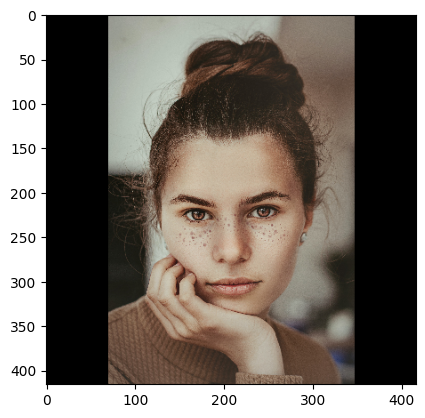

NMS
[tensor([[123.6825, 136.2603, 305.8475, 345.2425,   0.9956,   0.0000]])]
[tensor([[2.1476e+02, 2.4075e+02, 1.8217e+02, 2.0898e+02, 9.9574e-01, 9.9986e-01,
         1.3211e-04]], grad_fn=<IndexBackward0>)]
Face  0
tensor([2.1476e+02, 2.4075e+02, 1.8217e+02, 2.0898e+02, 9.9574e-01, 9.9986e-01,
        1.3211e-04], grad_fn=<UnbindBackward0>)
Cropped
123 136 306 346


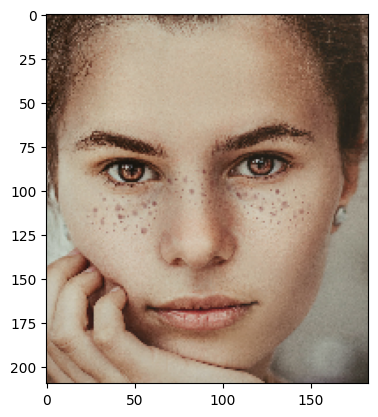

Resized


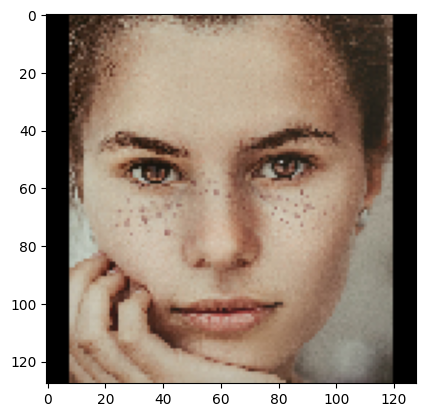

Gradient
torch.Size([1, 3, 416, 416])


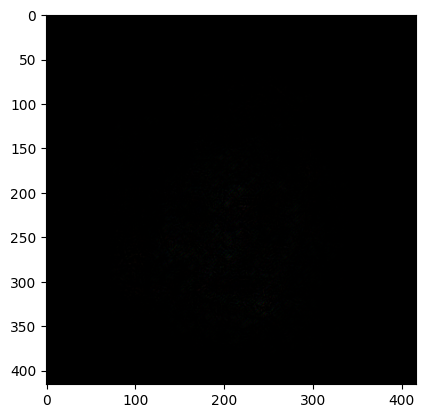

yunet min: 0.16999999999999998 mediapipe min: 0.2
can detect faces on unperturbed img? True
can detect faces on perturbed data with e=0.19? True
can detect faces on perturbed img? with e=0.19 False


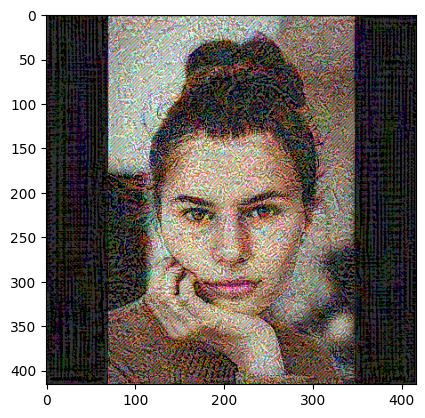

In [8]:
pipeline(model, device)

In [9]:
# it should not be able to detect this (but it can x_x)
def mp_det_fn(image):
    with minE.mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=0) as face_detection:
        results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        return results.detections is not None
mp_det_fn(cv2.imread("_2cantdetect.jpg"))

True

In [ ]:
class LocalBinaryPatterns:
  def __init__(self, numPoints, radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self, image, eps = 1e-7):
    lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints+3), range=(0, self.numPoints + 2))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp

# Extracts image's color channel
def extract_color_channel(image):
    # Read Source Image
    src = cv2.imread(image, cv2.IMREAD_UNCHANGED)

    # BGR Image Color Conversion
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
    hls = cv2.cvtColor(src, cv2.COLOR_BGR2HLS)
    lab = cv2.cvtColor(src, cv2.COLOR_BGR2LAB)
    ycrcb = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)

    # RGB Image Histogram
    red_hist = cv2.calcHist([rgb], [0], None, [256], [0, 255])
    green_hist = cv2.calcHist([rgb], [1], None, [256], [0, 255])
    blue_hist = cv2.calcHist([rgb], [2], None, [256], [0, 255])

    # HSV Image Histogram
    hue_hist_HSV = cv2.calcHist([hsv], [0], None, [256], [0, 255])
    saturation_hist_HSV = cv2.calcHist([hsv], [1], None, [256], [0, 255])
    value_hist = cv2.calcHist([hsv], [2], None, [256], [0, 255])

    # HLS Image Histogram
    hue_hist_HLS = cv2.calcHist([hls], [0], None, [256], [0, 255])
    lightness_hist_HLS = cv2.calcHist([hls], [1], None, [256], [0, 255])
    saturation_hist_HLS = cv2.calcHist([hls], [2], None, [256], [0, 255])

    # LAB Image Histogram
    lightness_hist_LAB = cv2.calcHist([lab], [0], None, [256], [0, 255])
    a_hist_LAB = cv2.calcHist([lab], [1], None, [256], [0, 255])
    b_hist_LAB = cv2.calcHist([lab], [2], None, [256], [0, 255])

    # YCrCb Image Histogram
    y_hist = cv2.calcHist([ycrcb], [0], None, [256], [0, 255])
    cr_hist = cv2.calcHist([ycrcb], [1], None, [256], [0, 255])
    cb_hist = cv2.calcHist([ycrcb], [2], None, [256], [0, 255])

    # RGB Image Plot
    plt.subplot(4, 1, 1)
    plt.imshow(rgb)
    plt.title('RGB Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 1, 2)
    plt.plot(red_hist, color='r')
    plt.xlim([0, 255])
    plt.ylim([0, 500])
    plt.title('Red Histogram')

    plt.subplot(4, 1, 3)
    plt.plot(green_hist, color='g')
    plt.xlim([0, 255])
    plt.ylim([0, 500])
    plt.title('Green Histogram')

    plt.subplot(4, 1, 4)
    plt.plot(blue_hist, color='b')
    plt.xlim([0, 255])
    plt.ylim([0, 500])
    plt.title('Blue Histogram')

    plt.tight_layout()
    plt.show()

    # HSV Image Plot
    plt.subplot(4, 1, 1)
    plt.imshow(hsv)
    plt.title('HSV Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 1, 2)
    plt.plot(hue_hist_HSV, color='c')
    plt.xlim([0, 255])
    plt.ylim([0, 2500])
    plt.title('Hue Histogram')

    plt.subplot(4, 1, 3)
    plt.plot(saturation_hist_HSV, color='m')
    plt.xlim([0, 255])
    plt.ylim([0, 1000])
    plt.title('Saturation Histogram')

    plt.subplot(4, 1, 4)
    plt.plot(value_hist, color='y')
    plt.xlim([0, 255])
    plt.ylim([0, 1000])
    plt.title('Value Histogram')

    plt.tight_layout()
    plt.show()

    # HLS Image Plot
    plt.subplot(4, 1, 1)
    plt.imshow(hls)
    plt.title('HLS Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 1, 2)
    plt.plot(hue_hist_HLS, color='r')
    plt.xlim([0, 255])
    plt.ylim([0, 2500])
    plt.title('Hue Histogram')

    plt.subplot(4, 1, 3)
    plt.plot(lightness_hist_HLS, color='g')
    plt.xlim([0, 255])
    plt.ylim([0, 1000])
    plt.title('Lightness Histogram')

    plt.subplot(4, 1, 4)
    plt.plot(saturation_hist_HLS, color='b')
    plt.xlim([0, 255])
    plt.ylim([0, 1000])
    plt.title('Saturation Histogram')

    plt.tight_layout()
    plt.show()

    # LAB Image Plot
    plt.subplot(4, 1, 1)
    plt.imshow(lab)
    plt.title('LAB Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 1, 2)
    plt.plot(lightness_hist_LAB, color='c')
    plt.xlim([0, 255])
    plt.ylim([0, 1000])
    plt.title('Lightness Histogram')

    plt.subplot(4, 1, 3)
    plt.plot(a_hist_LAB, color='m')
    plt.xlim([0, 255])
    plt.ylim([0, 20000])
    plt.title('A Histogram')

    plt.subplot(4, 1, 4)
    plt.plot(b_hist_LAB, color='y')
    plt.xlim([0, 255])
    plt.ylim([0, 20000])
    plt.title('B Histogram')

    plt.tight_layout()
    plt.show()

    # YCrCb Image Plot
    plt.subplot(4, 1, 1)
    plt.imshow(ycrcb)
    plt.title('YCrCb Image')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(4, 1, 2)
    plt.plot(y_hist, color='r')
    plt.xlim([0, 255])
    plt.ylim([0, 1000])
    plt.title('Y Histogram')

    plt.subplot(4, 1, 3)
    plt.plot(cr_hist, color='g')
    plt.xlim([0, 255])
    plt.ylim([0, 20000])
    plt.title('Cr Histogram')

    plt.subplot(4, 1, 4)
    plt.plot(cb_hist, color='b')
    plt.xlim([0, 255])
    plt.ylim([0, 20000])
    plt.title('Cb Histogram')

    plt.tight_layout()
    plt.show()

# Exctracts Local Binary Pattern of an image
def extract_lbp(image):
    orig = cv2.imread(image, cv2.IMREAD_UNCHANGED)
    gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

    desc = LocalBinaryPatterns(24, 8)
    lbp_hist, lbp_img = desc.describe(gray)

    plt.imshow(lbp_img, cmap = plt.get_cmap('gray'))
    plt.show()
    
def extract_gradients(image):
    # read the input image as a grayscale image
    img = cv2.imread(image, 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # compute the 1st order Sobel derivative in X-direction
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)

    # compute the 1st order Sobel derivative in Y-direction
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    # display sobelx and sobely
    plt.imshow(sobelx, cmap = "gray")
    plt.show()
    plt.imshow(sobely)
    plt.show()
    
# Inserts contents to the workbook
def insert_to_workbook(rng, content):
  rng.value = content

___